<a href="https://colab.research.google.com/github/josbex/HS-detection_in_social_media_posts/blob/master/Hate_speech_detection_in_social_media_posts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hate Speech detection in social media posts

## Using GPU for training BERT model

Go to: Edit -> Notebook settinngs -> Hardware accelerator -> (GPU)

In [1]:
import tensorflow as tf
import torch
import pandas as  pd
import re 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [3]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## Dataset

The dataset needs to be loaded from the drive (this entails the dataset is in your drive). If so, just run the cell below and follow the link to get an authorization code. 

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
def get_dataset(filename):
  df = pd.read_csv("/content/gdrive/My Drive/thesis/dataset/" + filename +".tsv", sep="\t") 
  #Saving tweets and their labels as numpy arrays
  tweets = df.tweet.values
  labels = df.label.values
  return tweets, labels

## BERT Tokenization 

Help for how to handle the tokenization in BERT was found here: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03

In [6]:
!pip install transformers

from transformers import BertTokenizer, BertModel, BertForMaskedLM
# OPTIONAL: if you want to have more information on what's happening under the hood, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 890kB 15.6MB/s 
     |████████████████████████████████| 3.0MB 13.2MB/s 
     |████████████████████████████████| 1.1MB 41.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=21af656776820d8e17ffa679923b39c79f2d9ac28675ddfb811e2f7a47403f01
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [7]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

INFO:filelock:Lock 140678797397688 acquired on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmphewqn83v


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt in cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO:filelock:Lock 140678797397688 released on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df4

##Investigate the data set

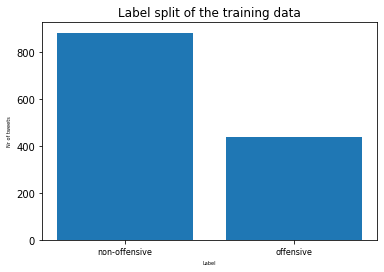

In [10]:
def count_occurences(labels):
  occurences = []
  OFFcount = np.count_nonzero(labels)
  occurences.append(len(labels)- OFFcount)
  occurences.append(OFFcount)
  return occurences

labelStr = ['non-offensive', 'offensive']
occurences = count_occurences(labels)

def plot_data(occurences, labelStr, xlabel, ylabel, title, name):
  fig = plt.figure()
  index = np.arange(len(labelStr))
  plt.bar(index, occurences)
  plt.xlabel(xlabel, fontsize=5)
  plt.ylabel(ylabel, fontsize=5)
  plt.xticks(index, labelStr, fontsize=8)
  plt.title(title)
  plt.show()
  fig.savefig("/content/gdrive/My Drive/thesis/dataset/" + name + ".png")

plot_data(occurences, labelStr, 'Label', 'Nr of tweets', 'Label split of the training data', 'label_split')

Max lenght of tweet:  169


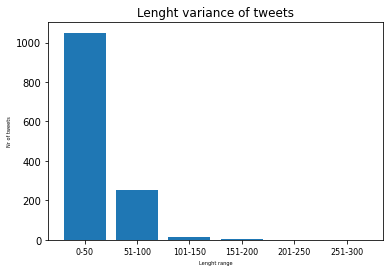

In [12]:
import collections

def get_token_lengths(tweets):
  token_lenghts = []
  for tweet in tweets:
    encoded_tweet = tokenizer(tweet)["input_ids"]
    token_lenghts.append(len(encoded_tweet))
  return token_lenghts

def label_count(counter):
  occurences = [0,0,0,0,0,0]
  for key, value in counter.items():
    if key < 51:
      occurences[0] += value
    elif key > 50 and key < 101:
      occurences[1] += value
    elif key > 100 and key < 151:
      occurences[2] += value
    elif key > 150 and key < 201:
      occurences[3] += value
    elif key > 200 and key < 251:
      occurences[4] += value
    else:
      occurences[5] += value
  return occurences
    
labelStr = ["0-50", "51-100", "101-150", "151-200", "201-250", "251-300"]
token_lenghts = get_token_lengths(tweets)
print("Max lenght of tweet: ", max(token_lenghts))
counter=collections.Counter(token_lenghts)
occurences = label_count(counter)
plot_data(occurences, labelStr, 'Lenght range', 'Nr of tweets', 'Lenght variance of tweets', 'lenght_split')


Guide on how to tokenize and turn the lists into tensors was found here: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

max_length was set to 150 (+2 for the [CLS] and [SEP] tokens) since the majority of the tweets aren't longer than that. Having a smaller max_len increases the speed of the training.

In [13]:
def data_to_tensors(tweets, labels):
  # Tokenize all of the sentences and map the tokens to their word IDs.
  input_ids = []
  attention_masks = []
  # For every sentence...
  #for tweet in seperated_tweets:
  for tweet in tweets:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Map tokens to their IDs.
      #   (3) Pad or truncate the sentence to `max_length`
      #   (4) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          tweet,                      # tweet to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'?
                          truncation=True,
                          max_length = 152,           # Pad & truncate all tweets.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

## Attention Mask

Since each tweet needs to be of the same lenght they have been padded to be of the same lenght as the longest tweet. BERT will not need to pay attention to the padding, thus attention masks are neeeded for each tweet to distingush between real input and padding. See more: https://huggingface.co/transformers/glossary.html#attention-mask


## Split data into training and validation sets
Guide also found here: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

Why it is good to have an validation set is because it is a good test to use for overfitting. Instead of just considering validation accuracy, validation loss can also be observed, which is basically a measurement of how confindent the model was on the correct prediction. 

In [9]:
from torch.utils.data import TensorDataset
# Combine the training inputs into a TensorDataset.
tweets, labels = get_dataset('90_training_data')
input_ids, attention_masks, labels = data_to_tensors(tweets, labels)
train_dataset = TensorDataset(input_ids, attention_masks, labels)

# Combine the validation inputs into a TensorDataset.
tweets, labels = get_dataset('10_val_data')
input_ids, attention_masks, labels = data_to_tensors(tweets, labels)
val_dataset = TensorDataset(input_ids, attention_masks, labels)

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

11,916 training samples
1,324 validation samples


The guide also recommed to create an iterator for the dataset since this save on memory compared to using regular for loops. See more: https://pytorch.org/docs/stable/data.html

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
def create_dataloaders(batch_size):
  # The DataLoader needs to know our batch size for training, so we specify it 
  # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
  # size of 16 or 32. 16 is choosen in this case because the GPU runs out of memory with 32
  batch_size = batch_size

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order. 
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  return train_dataloader, validation_dataloader

## Training the model

##Linear schedule with warmup
Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

In [15]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
def setup_model(epoch, learn_rate, train_dataloader):
  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2, # The number of output labels--2 for binary classification.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )

  # Tell pytorch to run this model on the GPU.
  model.cuda()
  #The epsilon parameter eps = 1e-8 is “a very small number to prevent any division by zero in the implementation”
  optimizer = AdamW(model.parameters(),
                    lr = learn_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
    # Number of training epochs. The BERT authors recommend between 2 and 4. 
  epochs = epoch

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  return model, optimizer, scheduler

In [16]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  #Get the highest predicions per tweet, and turn the result into a 1d list 
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  #sum up element-wise comparisons to calculate the average accuracy
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



In [ ]:
import random
from sklearn.metrics import f1_score

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []
mid_training_stats = []
mid_validation_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids,  
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Save training loss every 100th step
        if step % 100 == 0 and not step == 0:
          mid_training_stats.append({
                                    'epoch': epoch_i + 1,
                                    'Training Loss': loss.item(),
                                    'Step' : step
                                    })
          
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_f1_score = 0

    # Evaluate data for one epoch
    for step, batch in enumerate(validation_dataloader):
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test tweets, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_f1_score += f1_score(label_ids.flatten(), np.argmax(logits, axis=1).flatten(), average='macro')

        # Save accuracy every 10th step
        if step % 10 == 0 and not step == 0:
          mid_validation_stats.append({
                                    'epoch': epoch_i + 1,
                                    'Accuracy': flat_accuracy(logits, label_ids),
                                    'f1_score' : f1_score(label_ids.flatten(), np.argmax(logits, axis=1).flatten(), average='macro'),
                                    'Step' : step
                                    })
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Report the final f-1 score for this validation run.
    avg_f1_score = total_f1_score/len(validation_dataloader)
    print("  f-1 score: {0:.2f}".format(avg_f1_score))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Macro f-1 Score': avg_f1_score,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



In [18]:
import random
from sklearn.metrics import f1_score

def train_and_validate(model, optimizer, scheduler, train_dataloader, validation_dataloader, epochs):
    # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []
  mid_training_stats = []
  mid_validation_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          # It returns different numbers of parameters depending on what arguments
          # arge given and what flags are set. For our useage here, it returns
          # the loss (because we provided labels) and the "logits"--the model
          # outputs prior to activation.
          loss, logits = model(b_input_ids,  
                              attention_mask=b_input_mask, 
                              labels=b_labels)

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Save training loss every 100th step
          if step % 100 == 0 and not step == 0:
            mid_training_stats.append({
                                      'epoch': epoch_i + 1,
                                      'Training Loss': loss.item(),
                                      'Step' : step
                                      })
            
          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0
      total_f1_score = 0

      # Evaluate data for one epoch
      for step, batch in enumerate(validation_dataloader):
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              (loss, logits) = model(b_input_ids, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test tweets, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          total_f1_score += f1_score(label_ids.flatten(), np.argmax(logits, axis=1).flatten(), average='macro')

          # Save accuracy every 10th step
          if step % 10 == 0 and not step == 0:
            mid_validation_stats.append({
                                      'epoch': epoch_i + 1,
                                      'Accuracy': flat_accuracy(logits, label_ids),
                                      'f1_score' : f1_score(label_ids.flatten(), np.argmax(logits, axis=1).flatten(), average='macro'),
                                      'Step' : step
                                      })
          
      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Report the final f-1 score for this validation run.
      avg_f1_score = total_f1_score/len(validation_dataloader)
      print("  f-1 score: {0:.2f}".format(avg_f1_score))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Macro f-1 Score': avg_f1_score,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, training_stats, mid_training_stats, mid_validation_stats

In [19]:
def print_stats(stats):
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')

  # Display the table.
  display(df_stats)

#print_stats(training_stats)
#print_stats(mid_training_stats)
#print_stats(mid_validation_stats)

In [20]:
def start_training(epoch, batch_size, learn_rate):
  train_dataloader, validation_dataloader = create_dataloaders(batch_size)
  model, optimizer, scheduler = setup_model(epoch, learn_rate, train_dataloader)
  return train_and_validate(model, optimizer, scheduler, train_dataloader, validation_dataloader, epoch)

#TODO: add function where parameters and mid_training_stats gets saved to a tsv fil
def training_loop(parameter_list, valid_loss_range):
  best_stats = []
  best_parameters = {}
  for entry in parameter_list:
    print('Epochs: ', entry['epoch'])
    print('Batch size: ', entry['batch_size'])
    print('Learning rate: ', entry['learning_rate'])
    model, training_stats, mid_training_stats, mid_validation_stats = start_training(entry['epoch'], entry['batch_size'], entry['learning_rate'])
    if len(best_stats) == 0:
      best_stats = training_stats
      best_parameters = entry 
      save_model(model)
    elif (training_stats[len(training_stats)-1]['Macro f-1 Score'] >= best_stats[len(best_stats)-1]['Macro f-1 Score']) and (training_stats[len(training_stats)-1]['Training Loss'] < best_stats[len(best_stats)-1]['Training Loss']) and (abs(training_stats[len(training_stats)-1]['Valid. Loss'] - training_stats[len(training_stats)-1]['Training Loss']) < valid_loss_range):
      best_stats = training_stats
      best_parameters = entry  
      save_model(model)
    else:
      continue
  return best_stats, best_parameters 

In [21]:
meta_parameters = [{'batch_size' : 16, 'learning_rate' : 2e-5, 'epoch' : 2},
                   {'batch_size' : 16, 'learning_rate' : 2e-5, 'epoch' : 3},
                   {'batch_size' : 16, 'learning_rate' : 2e-5, 'epoch' : 4},
                   {'batch_size' : 16, 'learning_rate' : 3e-5, 'epoch' : 2},
                   {'batch_size' : 16, 'learning_rate' : 3e-5, 'epoch' : 3},
                   {'batch_size' : 16, 'learning_rate' : 3e-5, 'epoch' : 4},
                   {'batch_size' : 16, 'learning_rate' : 5e-5, 'epoch' : 2},
                   {'batch_size' : 16, 'learning_rate' : 5e-5, 'epoch' : 3},
                   {'batch_size' : 16, 'learning_rate' : 5e-5, 'epoch' : 4},
                   {'batch_size' : 32, 'learning_rate' : 2e-5, 'epoch' : 2},
                   {'batch_size' : 32, 'learning_rate' : 2e-5, 'epoch' : 3},
                   {'batch_size' : 32, 'learning_rate' : 2e-5, 'epoch' : 4},
                   {'batch_size' : 32, 'learning_rate' : 3e-5, 'epoch' : 2},
                   {'batch_size' : 32, 'learning_rate' : 3e-5, 'epoch' : 3},
                   {'batch_size' : 32, 'learning_rate' : 3e-5, 'epoch' : 4},
                   {'batch_size' : 32, 'learning_rate' : 5e-5, 'epoch' : 2},
                   {'batch_size' : 32, 'learning_rate' : 5e-5, 'epoch' : 3},
                   {'batch_size' : 32, 'learning_rate' : 5e-5, 'epoch' : 4}]

In [23]:
best_stats, best_parameters = training_loop(meta_parameters, 0.21)
print_stats(best_stats)
print(best_parameters)

Epochs:  2
Batch size:  16
Learning rate:  2e-05


INFO:filelock:Lock 140678777000624 acquired on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpta9us77n


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json in cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:filelock:Lock 140678777000624 released on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3

INFO:filelock:Lock 140678777000624 acquired on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock
INFO:transformers.file_utils:https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpwv_tknvc


INFO:transformers.file_utils:storing https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin in cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
INFO:filelock:Lock 140678777000624 released on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157


- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 2 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:31.
  Batch    80  of    745.    Elapsed: 0:01:02.
  Batch   120  of    745.    Elapsed: 0:01:33.
  Batch   160  of    745.    Elapsed: 0:02:04.
  Batch   200  of    745.    Elapsed: 0:02:35.
  Batch   240  of    745.    Elapsed: 0:03:06.
  Batch   280  of    745.    Elapsed: 0:03:37.
  Batch   320  of    745.    Elapsed: 0:04:08.
  Batch   360  of    745.    Elapsed: 0:04:39.
  Batch   400  of    745.    Elapsed: 0:05:10.
  Batch   440  of    745.    Elapsed: 0:05:40.
  Batch   480  of    745.    Elapsed: 0:06:11.
  Batch   520  of    745.    Elapsed: 0:06:41.
  Batch   560  of    745.    Elapsed: 0:07:12.
  Batch   600  of    745.    Elapsed: 0:07:42.
  Batch   640  of    745.    Elapsed: 0:08:13.
  Batch   680  of    745.    Elapsed: 0:08:43.
  Batch   720  of    745.    Elapsed: 0:09:14.

  Average training loss: 0.46
  Training epcoh took: 0:09:33

Running Validation...
  Accuracy: 0.82
  f-1 sco

INFO:transformers.configuration_utils:Configuration saved in ./model_save/config.json


  Accuracy: 0.80
  f-1 score: 0.77
  Validation Loss: 0.45
  Validation took: 0:00:22

Training complete!
Total training took 0:19:46 (h:mm:ss)
Saving model to ./model_save/


INFO:transformers.modeling_utils:Model weights saved in ./model_save/pytorch_model.bin


Epochs:  3
Batch size:  16
Learning rate:  2e-05


INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:31.
  Batch    80  of    745.    Elapsed: 0:01:01.
  Batch   120  of    745.    Elapsed: 0:01:31.
  Batch   160  of    745.    Elapsed: 0:02:02.
  Batch   200  of    745.    Elapsed: 0:02:33.
  Batch   240  of    745.    Elapsed: 0:03:03.
  Batch   280  of    745.    Elapsed: 0:03:33.
  Batch   320  of    745.    Elapsed: 0:04:04.
  Batch   360  of    745.    Elapsed: 0:04:34.
  Batch   400  of    745.    Elapsed: 0:05:05.
  Batch   440  of    745.    Elapsed: 0:05:36.
  Batch   480  of    745.    Elapsed: 0:06:06.
  Batch   520  of    745.    Elapsed: 0:06:37.
  Batch   560  of    745.    Elapsed: 0:07:07.
  Batch   600  of    745.    Elapsed: 0:07:38.
  Batch   640  of    745.    Elapsed: 0:08:08.
  Batch   680  of    745.    Elapsed: 0:08:39.
  Batch   720  of    745.    Elapsed: 0:09:09.

  Average training loss: 0.47
  Training epcoh took: 0:09:28

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:31.
  Batch    80  of    745.    Elapsed: 0:01:02.
  Batch   120  of    745.    Elapsed: 0:01:33.
  Batch   160  of    745.    Elapsed: 0:02:04.
  Batch   200  of    745.    Elapsed: 0:02:35.
  Batch   240  of    745.    Elapsed: 0:03:06.
  Batch   280  of    745.    Elapsed: 0:03:37.
  Batch   320  of    745.    Elapsed: 0:04:08.
  Batch   360  of    745.    Elapsed: 0:04:39.
  Batch   400  of    745.    Elapsed: 0:05:10.
  Batch   440  of    745.    Elapsed: 0:05:41.
  Batch   480  of    745.    Elapsed: 0:06:12.
  Batch   520  of    745.    Elapsed: 0:06:43.
  Batch   560  of    745.    Elapsed: 0:07:14.
  Batch   600  of    745.    Elapsed: 0:07:45.
  Batch   640  of    745.    Elapsed: 0:08:16.
  Batch   680  of    745.    Elapsed: 0:08:47.
  Batch   720  of    745.    Elapsed: 0:09:18.

  Average training loss: 0.47
  Training epcoh took: 0:09:37

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:31.
  Batch    80  of    745.    Elapsed: 0:01:02.
  Batch   120  of    745.    Elapsed: 0:01:33.
  Batch   160  of    745.    Elapsed: 0:02:04.
  Batch   200  of    745.    Elapsed: 0:02:35.
  Batch   240  of    745.    Elapsed: 0:03:06.
  Batch   280  of    745.    Elapsed: 0:03:37.
  Batch   320  of    745.    Elapsed: 0:04:08.
  Batch   360  of    745.    Elapsed: 0:04:39.
  Batch   400  of    745.    Elapsed: 0:05:10.
  Batch   440  of    745.    Elapsed: 0:05:41.
  Batch   480  of    745.    Elapsed: 0:06:12.
  Batch   520  of    745.    Elapsed: 0:06:43.
  Batch   560  of    745.    Elapsed: 0:07:14.
  Batch   600  of    745.    Elapsed: 0:07:45.
  Batch   640  of    745.    Elapsed: 0:08:16.
  Batch   680  of    745.    Elapsed: 0:08:47.
  Batch   720  of    745.    Elapsed: 0:09:18.

  Average training loss: 0.47
  Training epcoh took: 0:09:37

Running Validation...
  Accuracy: 0.80
  f-1 sco

INFO:transformers.configuration_utils:Configuration saved in ./model_save/config.json


  Accuracy: 0.81
  f-1 score: 0.77
  Validation Loss: 0.46
  Validation took: 0:00:23

Training complete!
Total training took 0:19:59 (h:mm:ss)
Saving model to ./model_save/


INFO:transformers.modeling_utils:Model weights saved in ./model_save/pytorch_model.bin


Epochs:  3
Batch size:  16
Learning rate:  3e-05


INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:31.
  Batch    80  of    745.    Elapsed: 0:01:02.
  Batch   120  of    745.    Elapsed: 0:01:33.
  Batch   160  of    745.    Elapsed: 0:02:04.
  Batch   200  of    745.    Elapsed: 0:02:35.
  Batch   240  of    745.    Elapsed: 0:03:06.
  Batch   280  of    745.    Elapsed: 0:03:37.
  Batch   320  of    745.    Elapsed: 0:04:08.
  Batch   360  of    745.    Elapsed: 0:04:39.
  Batch   400  of    745.    Elapsed: 0:05:10.
  Batch   440  of    745.    Elapsed: 0:05:41.
  Batch   480  of    745.    Elapsed: 0:06:12.
  Batch   520  of    745.    Elapsed: 0:06:43.
  Batch   560  of    745.    Elapsed: 0:07:14.
  Batch   600  of    745.    Elapsed: 0:07:45.
  Batch   640  of    745.    Elapsed: 0:08:16.
  Batch   680  of    745.    Elapsed: 0:08:47.
  Batch   720  of    745.    Elapsed: 0:09:18.

  Average training loss: 0.47
  Training epcoh took: 0:09:37

Running Validation...
  Accuracy: 0.82
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:31.
  Batch    80  of    745.    Elapsed: 0:01:03.
  Batch   120  of    745.    Elapsed: 0:01:34.
  Batch   160  of    745.    Elapsed: 0:02:06.
  Batch   200  of    745.    Elapsed: 0:02:37.
  Batch   240  of    745.    Elapsed: 0:03:08.
  Batch   280  of    745.    Elapsed: 0:03:40.
  Batch   320  of    745.    Elapsed: 0:04:11.
  Batch   360  of    745.    Elapsed: 0:04:42.
  Batch   400  of    745.    Elapsed: 0:05:13.
  Batch   440  of    745.    Elapsed: 0:05:44.
  Batch   480  of    745.    Elapsed: 0:06:15.
  Batch   520  of    745.    Elapsed: 0:06:46.
  Batch   560  of    745.    Elapsed: 0:07:17.
  Batch   600  of    745.    Elapsed: 0:07:48.
  Batch   640  of    745.    Elapsed: 0:08:19.
  Batch   680  of    745.    Elapsed: 0:08:50.
  Batch   720  of    745.    Elapsed: 0:09:21.

  Average training loss: 0.47
  Training epcoh took: 0:09:40

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:31.
  Batch    80  of    745.    Elapsed: 0:01:02.
  Batch   120  of    745.    Elapsed: 0:01:33.
  Batch   160  of    745.    Elapsed: 0:02:04.
  Batch   200  of    745.    Elapsed: 0:02:35.
  Batch   240  of    745.    Elapsed: 0:03:06.
  Batch   280  of    745.    Elapsed: 0:03:37.
  Batch   320  of    745.    Elapsed: 0:04:08.
  Batch   360  of    745.    Elapsed: 0:04:39.
  Batch   400  of    745.    Elapsed: 0:05:10.
  Batch   440  of    745.    Elapsed: 0:05:41.
  Batch   480  of    745.    Elapsed: 0:06:12.
  Batch   520  of    745.    Elapsed: 0:06:43.
  Batch   560  of    745.    Elapsed: 0:07:14.
  Batch   600  of    745.    Elapsed: 0:07:45.
  Batch   640  of    745.    Elapsed: 0:08:16.
  Batch   680  of    745.    Elapsed: 0:08:47.
  Batch   720  of    745.    Elapsed: 0:09:18.

  Average training loss: 0.47
  Training epcoh took: 0:09:37

Running Validation...
  Accuracy: 0.82
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:31.
  Batch    80  of    745.    Elapsed: 0:01:02.
  Batch   120  of    745.    Elapsed: 0:01:33.
  Batch   160  of    745.    Elapsed: 0:02:04.
  Batch   200  of    745.    Elapsed: 0:02:35.
  Batch   240  of    745.    Elapsed: 0:03:06.
  Batch   280  of    745.    Elapsed: 0:03:37.
  Batch   320  of    745.    Elapsed: 0:04:08.
  Batch   360  of    745.    Elapsed: 0:04:39.
  Batch   400  of    745.    Elapsed: 0:05:10.
  Batch   440  of    745.    Elapsed: 0:05:41.
  Batch   480  of    745.    Elapsed: 0:06:12.
  Batch   520  of    745.    Elapsed: 0:06:43.
  Batch   560  of    745.    Elapsed: 0:07:14.
  Batch   600  of    745.    Elapsed: 0:07:45.
  Batch   640  of    745.    Elapsed: 0:08:16.
  Batch   680  of    745.    Elapsed: 0:08:47.
  Batch   720  of    745.    Elapsed: 0:09:18.

  Average training loss: 0.48
  Training epcoh took: 0:09:37

Running Validation...
  Accuracy: 0.82
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:31.
  Batch    80  of    745.    Elapsed: 0:01:02.
  Batch   120  of    745.    Elapsed: 0:01:32.
  Batch   160  of    745.    Elapsed: 0:02:03.
  Batch   200  of    745.    Elapsed: 0:02:34.
  Batch   240  of    745.    Elapsed: 0:03:05.
  Batch   280  of    745.    Elapsed: 0:03:36.
  Batch   320  of    745.    Elapsed: 0:04:06.
  Batch   360  of    745.    Elapsed: 0:04:37.
  Batch   400  of    745.    Elapsed: 0:05:08.
  Batch   440  of    745.    Elapsed: 0:05:39.
  Batch   480  of    745.    Elapsed: 0:06:10.
  Batch   520  of    745.    Elapsed: 0:06:41.
  Batch   560  of    745.    Elapsed: 0:07:11.
  Batch   600  of    745.    Elapsed: 0:07:42.
  Batch   640  of    745.    Elapsed: 0:08:13.
  Batch   680  of    745.    Elapsed: 0:08:44.
  Batch   720  of    745.    Elapsed: 0:09:15.

  Average training loss: 0.49
  Training epcoh took: 0:09:34

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:47.
  Batch   200  of    373.    Elapsed: 0:04:44.
  Batch   240  of    373.    Elapsed: 0:05:40.
  Batch   280  of    373.    Elapsed: 0:06:37.
  Batch   320  of    373.    Elapsed: 0:07:34.
  Batch   360  of    373.    Elapsed: 0:08:31.

  Average training loss: 0.48
  Training epcoh took: 0:08:48

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:54.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:47.
  Batch   200  of    373.    Elapsed: 0:04:44.
  Batch   240  of    373.    Elapsed: 0:05:41.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:47.
  Batch   200  of    373.    Elapsed: 0:04:44.
  Batch   240  of    373.    Elapsed: 0:05:40.
  Batch   280  of    373.    Elapsed: 0:06:37.
  Batch   320  of    373.    Elapsed: 0:07:34.
  Batch   360  of    373.    Elapsed: 0:08:31.

  Average training loss: 0.49
  Training epcoh took: 0:08:48

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.79
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:54.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:47.
  Batch   200  of    373.    Elapsed: 0:04:44.
  Batch   240  of    373.    Elapsed: 0:05:41.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:56.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:49.
  Batch   160  of    373.    Elapsed: 0:03:45.
  Batch   200  of    373.    Elapsed: 0:04:42.
  Batch   240  of    373.    Elapsed: 0:05:38.
  Batch   280  of    373.    Elapsed: 0:06:35.
  Batch   320  of    373.    Elapsed: 0:07:31.
  Batch   360  of    373.    Elapsed: 0:08:27.

  Average training loss: 0.47
  Training epcoh took: 0:08:45

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:56.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:49.
  Batch   160  of    373.    Elapsed: 0:03:45.
  Batch   200  of    373.    Elapsed: 0:04:41.
  Batch   240  of    373.    Elapsed: 0:05:38.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:47.
  Batch   200  of    373.    Elapsed: 0:04:44.
  Batch   240  of    373.    Elapsed: 0:05:41.
  Batch   280  of    373.    Elapsed: 0:06:37.
  Batch   320  of    373.    Elapsed: 0:07:34.
  Batch   360  of    373.    Elapsed: 0:08:31.

  Average training loss: 0.47
  Training epcoh took: 0:08:49

Running Validation...
  Accuracy: 0.81
  f-1 score: 0.77
  Validation Loss: 0.41
  Validation took: 0:00:22

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:47.
  Batch   200  of    373.    Elapsed: 0:04:44.
  Batch   240  of    373.    Elapsed: 0:05:41.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:47.
  Batch   200  of    373.    Elapsed: 0:04:44.
  Batch   240  of    373.    Elapsed: 0:05:40.
  Batch   280  of    373.    Elapsed: 0:06:37.
  Batch   320  of    373.    Elapsed: 0:07:34.
  Batch   360  of    373.    Elapsed: 0:08:31.

  Average training loss: 0.47
  Training epcoh took: 0:08:49

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.77
  Validation Loss: 0.43
  Validation took: 0:00:22

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:54.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:46.
  Batch   200  of    373.    Elapsed: 0:04:42.
  Batch   240  of    373.    Elapsed: 0:05:39.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:47.
  Batch   200  of    373.    Elapsed: 0:04:43.
  Batch   240  of    373.    Elapsed: 0:05:40.
  Batch   280  of    373.    Elapsed: 0:06:36.
  Batch   320  of    373.    Elapsed: 0:07:33.
  Batch   360  of    373.    Elapsed: 0:08:30.

  Average training loss: 0.47
  Training epcoh took: 0:08:47

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:47.
  Batch   200  of    373.    Elapsed: 0:04:44.
  Batch   240  of    373.    Elapsed: 0:05:40.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:46.
  Batch   200  of    373.    Elapsed: 0:04:43.
  Batch   240  of    373.    Elapsed: 0:05:40.
  Batch   280  of    373.    Elapsed: 0:06:36.
  Batch   320  of    373.    Elapsed: 0:07:33.
  Batch   360  of    373.    Elapsed: 0:08:30.

  Average training loss: 0.47
  Training epcoh took: 0:08:47

Running Validation...
  Accuracy: 0.81
  f-1 score: 0.77
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:56.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:46.
  Batch   200  of    373.    Elapsed: 0:04:43.
  Batch   240  of    373.    Elapsed: 0:05:40.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:Configuration saved in ./model_save/config.json


  Accuracy: 0.81
  f-1 score: 0.78
  Validation Loss: 0.45
  Validation took: 0:00:22

Training complete!
Total training took 0:18:17 (h:mm:ss)
Saving model to ./model_save/


INFO:transformers.modeling_utils:Model weights saved in ./model_save/pytorch_model.bin


Epochs:  3
Batch size:  32
Learning rate:  5e-05


INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:56.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:46.
  Batch   200  of    373.    Elapsed: 0:04:43.
  Batch   240  of    373.    Elapsed: 0:05:39.
  Batch   280  of    373.    Elapsed: 0:06:35.
  Batch   320  of    373.    Elapsed: 0:07:31.
  Batch   360  of    373.    Elapsed: 0:08:28.

  Average training loss: 0.49
  Training epcoh took: 0:08:45

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.77
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:46.
  Batch   200  of    373.    Elapsed: 0:04:42.
  Batch   240  of    373.    Elapsed: 0:05:39.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:46.
  Batch   200  of    373.    Elapsed: 0:04:43.
  Batch   240  of    373.    Elapsed: 0:05:39.
  Batch   280  of    373.    Elapsed: 0:06:36.
  Batch   320  of    373.    Elapsed: 0:07:33.
  Batch   360  of    373.    Elapsed: 0:08:29.

  Average training loss: 0.48
  Training epcoh took: 0:08:47

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:53.
  Batch   120  of    373.    Elapsed: 0:02:50.
  Batch   160  of    373.    Elapsed: 0:03:46.
  Batch   200  of    373.    Elapsed: 0:04:43.
  Batch   240  of    373.    Elapsed: 0:05:40.
  Batch   280  of    373.    Elapsed: 

,Training Loss,Valid. Loss,Valid. Accur.,Macro f-1 Score,Training Time,Validation Time
epoch,,,,,,
1,0.47,0.42,0.81,0.77,0:08:47,0:00:22
2,0.33,0.45,0.81,0.78,0:08:47,0:00:22


{'batch_size': 32, 'learning_rate': 5e-05, 'epoch': 2}


##Testing the model

In [ ]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("/content/gdrive/My Drive/thesis/dataset/test_data.tsv", sep="\t") 
#Saving tweets and their labels as numpy arrays
tweets = df.tweet.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for tweet in tweets:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True,
                        max_length = 152,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
from sklearn.metrics import confusion_matrix
# Prediction on test set

test_total_accuracy = 0
test_total_f1_score = 0

print('Predicting labels for {:,} test tweets...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  test_total_accuracy += flat_accuracy(logits, label_ids)
  test_total_f1_score += f1_score(label_ids.flatten(), np.argmax(logits, axis=1).flatten(), average='macro')

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Report the final accuracy for the testing
test_avg_val_accuracy = test_total_accuracy / len(predictions)
print("  Accuracy: {0:.2f}".format(test_avg_val_accuracy))

# Report the final f-1 score for the testing
test_avg_f1_score = test_total_f1_score/len(predictions)
print("  f-1 score: {0:.2f}".format(test_avg_f1_score))

print('DONE.')

#print(len(predictions))
#print(predictions[0])
#print('true labels: ', true_labels[0])

Predicting labels for 860 test tweets...
  Accuracy: 0.85
  f-1 score: 0.80
DONE.
[[ 0.19964452 -0.4894073 ]
 [ 2.3053718  -2.8952978 ]
 [ 0.46128982 -0.20588054]
 [ 2.6924329  -3.2007976 ]
 [ 2.785924   -3.2774231 ]
 [-1.7099606   2.281059  ]
 [-1.0642517   1.4445381 ]
 [-0.9601262   1.6105483 ]
 [ 2.7512772  -3.4065213 ]
 [ 2.5972726  -3.153022  ]
 [ 2.5193563  -3.2100868 ]
 [ 2.385592   -2.8634112 ]
 [-1.9515537   2.4275718 ]
 [ 2.682632   -3.208089  ]
 [ 0.42184615 -0.20716976]
 [-2.1017802   2.6546178 ]]
true labels:  [1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1]


In [ ]:
def predictions_flattened(predictions):
  new_pred = []
  for pred in predictions:
    batch = np.argmax(pred, axis=1).flatten()
    for b in batch:
      new_pred.append(b)
  return new_pred 

def true_labels_flattened(true_labels):
  flat_labels = []
  for labels in true_labels:
    for label in labels:
      flat_labels.append(label)
  return flat_labels

In [ ]:
tn, fp, fn, tp = confusion_matrix(true_labels_flattened(true_labels), predictions_flattened(predictions)).ravel()
cm = confusion_matrix(true_labels_flattened(true_labels), predictions_flattened(predictions))
print('true negative: ' , tn, '\nfalse negative: ', fn, '\ntrue positive: ', tp, '\nfalse positive: ', fp)
print(cm)

true negative:  559 
false negative:  71 
true positive:  169 
false positive:  61
[[559  61]
 [ 71 169]]


##Save fine-tuned model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

INFO:transformers.configuration_utils:Configuration saved in ./model_save/config.json


Saving model to ./model_save/


INFO:transformers.modeling_utils:Model weights saved in ./model_save/pytorch_model.bin


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./gdrive/My Drive/thesis/model"


In [22]:
import os
def save_model(model):
  # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

  output_dir = './model_save/'

  # Create output directory if needed
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  print("Saving model to %s" % output_dir)

  # Save a trained model, configuration and tokenizer using `save_pretrained()`.
  # They can then be reloaded using `from_pretrained()`
  model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
  model_to_save.save_pretrained(output_dir)
  tokenizer.save_pretrained(output_dir)
  # Copy the model files to a directory in your Google Drive.
  !cp -r ./model_save/ "./gdrive/My Drive/thesis/model"

#Load saved model

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)
